## Overview

One of the funner/more popular tricks you can employ using Deep Learning is the notion of style transfer between two images, like the canonical examples shown below.

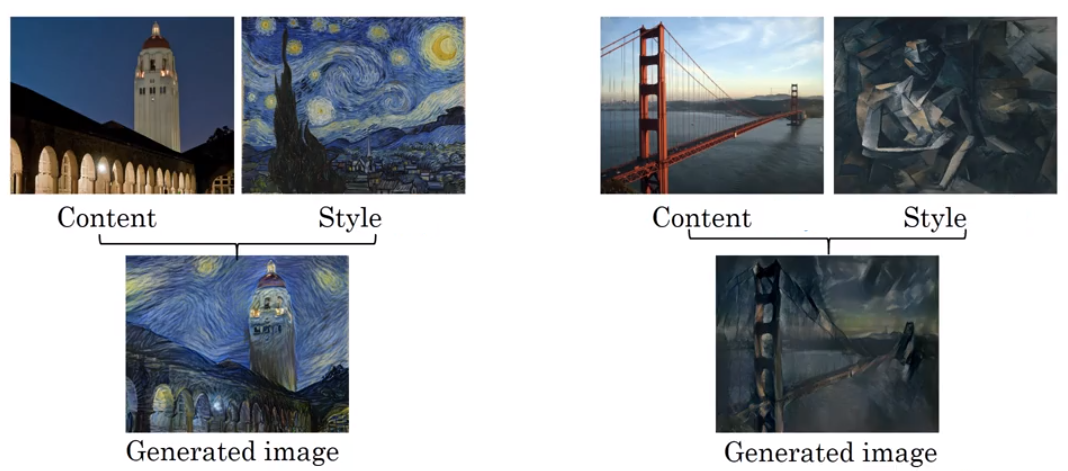

In [3]:
from IPython.display import Image

Image('images/style_transfer.png')

To get started, you want to determine some cost function that takes into consideration both:

- **Content**: how similar the principal shapes are between the Content Image and the Generated Image (e.g. the bridge clock tower)
- **Style**: How much the Generated Image "looks/feels" like the Style Image

(more on these below)

Actually working the algorithm is as follows:


- Start with some pre-trained model (VGG seems to be the most popular)
- Instantiate some completely-random image `G` with the same resolution as your intended output
- Compute the cost of your generated image, as outlined above
- Modify the image to minimize the cost
- Rinse, repeat

## Determining Cost

As previously mentioned, there are two aspects to our notion of cost: content and style

### Content Cost

This one's pretty straight-forward. Two images that have similar content have objects/pixel values that activate in about the same locations.

Thus, if we were to crack open some arbitrary intermediate VGG layer, run both images through it, and inspect the activation values, we'd expect to see a high degree of similarity between images of similar spatial-content and a low degree otherwise.

Extending this further, we can consider the distance between the activations of a particular layer, `l`, between the Content Image and Generated Image as a cost that we want to minimize.

$Jstyle(C, G) = || a^{\lbrack l \rbrack(C)} - a^{\lbrack l \rbrack(G)}|| ^{2}$

### Style Cost

This one's a bit trickier.

**Note**, the design of this approach relies heavily on the intuition that *we extract increasingly-complex features as we look at later convolutional layers*.

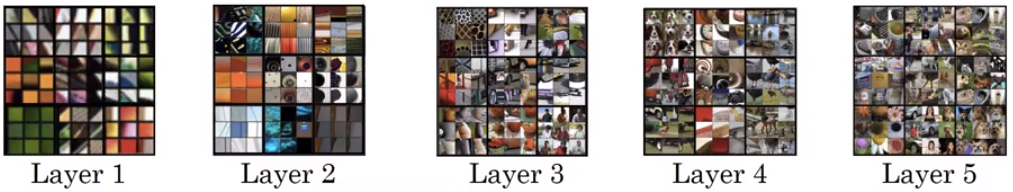

In [4]:
Image('images/layer_over_layer.png')

Thus, in our selection of layer `l`, we should be aiming for a more-intermediate layer-- not primative enough that we're just looking for edges, not advanced enough that we accidentally attribute "number of dogs in frame" as style.

From there we employ a similar "correlation-type" idea as before, except this time instead of looking at pairwise correlations of activations, this time we're comparing *the inter-relatedness between channels of a layer, for a given image.*

More concretely, because each channel can have dramatically different representations, the value that you get when you unroll everything and correlate is **extremely specific**-- for instance:

- Liberal use of rounded edges in one layer
- Pastel coloration in another
- Complementary colors often found right next to each other in a third

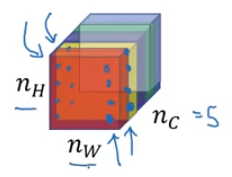

In [6]:
Image('images/style_corr.png')

Running our Style Image thorough the "sum everything up" operation will yield a specific value.

Then, once we run our not-yet-similar Generated Image through it, we might find that it's close-ish, perhaps checking 2 of the 3 boxes above. We feed this information to whatever optimizer we're using and it determines that we could achieve a closer score by modifying the image in a way that improves in this third, poor-performing channel.

#### The Math

Assume that a given layer, `l` with width `w`, height `h`, and channels `c`, has activation values (`i`, `j`, `k`) for each dimension, respectively. Then any given activation value would be written as

$a^{\lbrack l \rbrack}(i, j, k)$

And our "sum everything up" operation is actually just creating a Gram Matrix `G`, operating between two channels `k` and `k_prime`, where

$G(k, k')^{\lbrack l \rbrack} = \sum_{i}^{n_H}    \sum_{j}^{n_W} a(i,j,k) * a(i, j, k')$

This is basically one matrix transposed, dot-multiplied by the other. If the output of this is high, the two channels are highly-correlated.

Finally, we calculate the Style Loss between the Style Image and the Generated Image as

$Jstyle(S, G) = \frac{1}{4n_W^2n_H^2n_C^2} ||G^{\lbrack l \rbrack (S)} - G^{\lbrack l \rbrack (G)}||^{2}$

And this just is another (albeit, more-complicated) distance measure, with a normalizing factor out front to ease computation woes.

### Drawing From More Layers

We the intuition behind layer selection above. However, many implementations of neural style transfer instead draw from *multiple* hidden layers for each step, each with some pre-determined weighting that influences how things converge.

$Jstyle(S, G) = \sum_{l} \lambda^{\lbrack l \rbrack} Jstyle^{\lbrack l \rbrack }(S, G)$

## Better Resources than My Shorthand

- [Neural Style in Keras](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py)
- [Intuition Post 1](https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199)
- [Intuition Post 2](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)